In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F
from torchviz import make_dot


In [35]:
device = torch.device("cuda2" if torch.cuda.is_available() else "cpu")

In [36]:
class Logistic:
    def __init__(self, X_train, Y_train, epoch=100, learning_rate=0.01):
        self.X_train = X_train
        self.Y_train = Y_train
        self.epoch = epoch
        self.learning_rate = learning_rate
        self.Y_train = self.one_hot_encode(Y_train)
        self.num_classes = self.Y_train.shape[1]
        self.num_features = self.X_train.shape[1]
        self.Weights = np.zeros((self.num_features, self.num_classes))
        self.Bias = np.zeros((1, self.num_classes))
        self.Weights_array = []
        self.Bias_array = []
        self.Weights_array.append(self.Weights)
        self.Bias_array.append(self.Bias)
        self.loss_array = []
        self.accuracy_array = []
        
    def one_hot_encode(self, Y):
        one_hot = np.zeros((Y.size, Y.max() + 1))
        one_hot[np.arange(Y.size), Y] = 1
        return one_hot

    # ADD BOTH STOCHASTIC AND MINI BATCH GRADIENT DESCENT
    def train(self):
        for i in range(self.epoch):
            # print(f"Epoch {i+1} begins, value of Weights => {self.Weights}, value of Bias => {self.Bias}")
            activation = self.activation()
            # print(f"Activation => {activation}")
            grad_wrt_W = -np.matmul(self.X_train.T, (self.Y_train - activation))
            grad_wrt_B = -np.sum(self.Y_train - activation, axis=0, keepdims=True)

            self.Weights -= self.learning_rate * grad_wrt_W
            self.Bias -= self.learning_rate * grad_wrt_B

            self.Weights_array.append(self.Weights)
            self.Bias_array.append(self.Bias)

            # print(f"Epoch {i+1} ends, value of Weights => {self.Weights}, value of Bias => {self.Bias}")

            loss = self.loss(activation)
            self.loss_array.append(loss)
            accuracy = self.accuracy(activation)
            self.accuracy_array.append(accuracy)
            print(f"Epoch : {i+1} || Loss => {loss:.4f} || Accuracy => {accuracy:.4f}\n----------------------")

    def train_stochastic(self):
        for i in range(self.epoch):
            for j in range(self.X_train.shape[0]):
                activation = self.activation_stochastic(self.X_train[j].reshape(1, -1))
                grad_wrt_W = -np.matmul(self.X_train[j].reshape(-1, 1), (self.Y_train[j] - activation))
                grad_wrt_B = -np.sum(self.Y_train[j] - activation, axis=0, keepdims=True)

                self.Weights -= self.learning_rate * grad_wrt_W
                self.Bias -= self.learning_rate * grad_wrt_B

            self.Weights_array.append(self.Weights)
            self.Bias_array.append(self.Bias)

            activation = self.activation()
            loss = self.loss(activation)
            self.loss_array.append(loss)
            accuracy = self.accuracy(activation)
            self.accuracy_array.append(accuracy)
            print(f"Epoch : {i+1} || Loss => {loss:.4f} || Accuracy => {accuracy:.4f}\n----------------------")

    def activation_stochastic(self, X):
        linear_model = np.dot(X, self.Weights) + self.Bias
        return self.softmax(linear_model)

    def activation(self):
        linear_model = np.dot(self.X_train, self.Weights) + self.Bias
        return self.softmax(linear_model)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def loss(self, activation):
        m = self.Y_train.shape[0]
        log_likelihood = -np.log(activation[range(m), np.argmax(self.Y_train, axis=1)])
        loss = np.sum(log_likelihood) / m
        return loss

    def accuracy(self, activation):
        predictions = np.argmax(activation, axis=1)
        actuals = np.argmax(self.Y_train, axis=1)
        return np.mean(predictions == actuals)
    
    def test_accuracy(self, X_test, Y_test):
        Y_test = self.one_hot_encode(Y_test)
        activation = self.softmax(np.dot(X_test, self.Weights) + self.Bias)
        predictions = np.argmax(activation, axis=1)
        actuals = np.argmax(Y_test, axis=1)
        return np.mean(predictions == actuals)
    

In [37]:
class Logistic_torch(torch.nn.Module):
    def __init__(self, X_train, Y_train, epoch=100, learning_rate=0.01):
        super(Logistic_torch, self).__init__()
        self.X_train = X_train
        self.Y_train = Y_train

        # check if X_train and Y_train are torch tensors
        if not torch.is_tensor(self.X_train):
            self.X_train = torch.tensor(self.X_train, dtype=torch.float32, device=device)
        if not torch.is_tensor(self.Y_train):
            self.Y_train = torch.tensor(self.Y_train, dtype=torch.long, device=device)
        self.epoch = epoch
        self.learning_rate = learning_rate
        self.Y_train = self.one_hot_encode(Y_train)
        self.num_classes = self.Y_train.shape[1]
        self.num_features = self.X_train.shape[1]
        self.Weights = torch.zeros((self.num_features, self.num_classes), dtype=torch.float32, device=device, requires_grad=True)
        self.Bias = torch.zeros((1, self.num_classes), dtype=torch.float32, device=device, requires_grad=True)
        self.Weights_array = []
        self.Bias_array = []
        self.Weights_array.append(self.Weights)
        self.Bias_array.append(self.Bias)
        self.loss_array = []
        self.accuracy_array = []
        
    def one_hot_encode(self, Y):
        one_hot = torch.zeros((Y.size(0), Y.max() + 1), device=device)
        one_hot[torch.arange(Y.size(0)), Y] = 1
        return one_hot

    # ADD BOTH STOCHASTIC AND MINI BATCH GRADIENT DESCENT
    def train(self):
        for i in range(self.epoch):
            # print(f"Epoch {i+1} begins, value of Weights => {self.Weights}, value of Bias => {self.Bias}")
            activation = self.activation()
            # print(f"Activation => {activation}")
            loss = self.loss(activation)
            loss.backward()
            with torch.no_grad():
                self.Weights -= self.learning_rate * self.Weights.grad
                self.Bias -= self.learning_rate * self.Bias.grad
                self.Weights.grad.zero_()
                self.Bias.grad.zero_()
            self.Weights_array.append(self.Weights)
            self.Bias_array.append(self.Bias)
            self.loss_array.append(loss.item())
            accuracy = self.accuracy(activation)
            self.accuracy_array.append(accuracy)
            if(i == self.epoch-1):
                make_dot(loss).render("loss", format="png")
            print(f"Epoch : {i+1} || Loss => {loss.item():.4f} || Accuracy => {accuracy:.4f}\n----------------------")

    def train_stochastic(self):
        for i in range(self.epoch):
            for j in range(self.X_train.shape[0]):
                activation = self.activation_stochastic(self.X_train[j].reshape(1, -1))
                loss = self.loss(activation)
                loss.backward()
                with torch.no_grad():
                    self.Weights -= self.learning_rate * self.Weights.grad
                    self.Bias -= self.learning_rate * self.Bias.grad
                    self.Weights.grad.zero_()
                    self.Bias.grad.zero_()
                # save the graph of loss in the form of a png file named loss{i}.png in a given folder
            self.Weights_array.append(self.Weights)
            self.Bias_array.append(self.Bias)

            activation = self.activation()
            loss = self.loss(activation)
            self.loss_array.append(loss)
            accuracy = self.accuracy(activation)
            self.accuracy_array.append(accuracy)
            if(i == self.epoch-1):
                make_dot(loss).render("loss", format="png")
            print(f"Epoch : {i+1} || Loss => {loss:.4f} || Accuracy => {accuracy:.4f}\n----------------------")

    def activation_stochastic(self, X):
        linear_model = torch.matmul(X, self.Weights) + self.Bias
        return self.softmax(linear_model)

    def activation(self):
        linear_model = torch.matmul(self.X_train, self.Weights) + self.Bias
        return self.softmax(linear_model)

    def softmax(self, z):
        exp_z = torch.exp(z - torch.max(z, axis=1, keepdim=True).values)
        return exp_z / torch.sum(exp_z, axis=1, keepdim=True)

    def loss(self, activation):
        m = self.Y_train.shape[0]
        log_likelihood = -torch.log(activation[torch.arange(m), torch.argmax(self.Y_train, axis=1)])
        loss = torch.sum(log_likelihood) / m
        return loss

    def accuracy(self, activation):
        predictions = torch.argmax(activation, axis=1)
        actuals = torch.argmax(self.Y_train, axis=1)
        count = torch.sum(predictions == actuals)
        return count.item() / self.Y_train.shape[0]
    
    def test_accuracy(self, X_test, Y_test):
        Y_test = self.one_hot_encode(Y_test)
        activation = self.softmax(torch.matmul(X_test, self.Weights) + self.Bias)
        predictions = torch.argmax(activation, axis=1)
        actuals = torch.argmax(Y_test, axis=1)
        count = torch.sum(predictions == actuals)
        return count.item() / Y_test.shape[0]

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\dikss\AppData\Local\Temp\ipykernel_96924\1924613437.py:1: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv('C:\\Users\dikss\Capstone Projects\Data-Science-Capstones\Perceptron\iris.data', index_col=None, header=None)


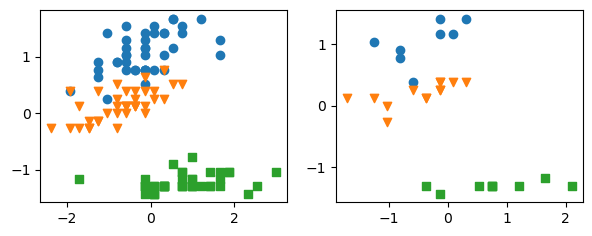

In [38]:
df = pd.read_csv('C:\\Users\dikss\Capstone Projects\Data-Science-Capstones\Perceptron\iris.data', index_col=None, header=None)
df.columns = ['x1', 'x2', 'x3', 'x4', 'y']

d = {'Iris-versicolor': 1,
     'Iris-virginica': 2,
     'Iris-setosa': 0,
}

df['y'] = df['y'].map(d)

# Assign features and target

X = torch.tensor(df[['x2', 'x4']].values, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.int)

# Shuffling & train/test split

torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)

X, y = X[shuffle_idx], y[shuffle_idx]

percent80 = int(shuffle_idx.size(0)*0.8)

X_train, X_test = X[shuffle_idx[:percent80]], X[shuffle_idx[percent80:]]
y_train, y_test = y[shuffle_idx[:percent80]], y[shuffle_idx[percent80:]]

# Normalize (mean zero, unit variance)

mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma


fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))
ax[0].scatter(X_train[y_train == 2, 0], X_train[y_train == 2, 1])
ax[0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], marker='v')
ax[0].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], marker='s')
ax[1].scatter(X_test[y_test == 2, 0], X_test[y_test == 2, 1])
ax[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], marker='v')
ax[1].scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], marker='s')
plt.show()

In [39]:
model = Logistic(X_train.numpy(),y_train.numpy(),1000,0.001)
model.train_stochastic()
print("Test Accuracy: ",model.test_accuracy(X_test.numpy(),y_test.numpy()))

model_batch = Logistic(X_train.numpy(),y_train.numpy(),1000,0.001)
model_batch.train()
print("Test Accuracy: ",model_batch.test_accuracy(X_test.numpy(),y_test.numpy()))

Epoch : 1 || Loss => 1.0480 || Accuracy => 0.8333
----------------------
Epoch : 2 || Loss => 1.0022 || Accuracy => 0.8333
----------------------
Epoch : 3 || Loss => 0.9606 || Accuracy => 0.8333
----------------------
Epoch : 4 || Loss => 0.9228 || Accuracy => 0.8333
----------------------
Epoch : 5 || Loss => 0.8886 || Accuracy => 0.8333
----------------------
Epoch : 6 || Loss => 0.8574 || Accuracy => 0.8333
----------------------
Epoch : 7 || Loss => 0.8291 || Accuracy => 0.8333
----------------------
Epoch : 8 || Loss => 0.8032 || Accuracy => 0.8333
----------------------
Epoch : 9 || Loss => 0.7795 || Accuracy => 0.8333
----------------------
Epoch : 10 || Loss => 0.7578 || Accuracy => 0.8333
----------------------
Epoch : 11 || Loss => 0.7379 || Accuracy => 0.8333
----------------------
Epoch : 12 || Loss => 0.7195 || Accuracy => 0.8333
----------------------
Epoch : 13 || Loss => 0.7025 || Accuracy => 0.8333
----------------------
Epoch : 14 || Loss => 0.6868 || Accuracy => 0.8

C:\Users\dikss\AppData\Local\Temp\ipykernel_96924\816947699.py:25: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax1.set_xlim([class_1_feature_1.min() , class_1_feature_1.max() ])
C:\Users\dikss\AppData\Local\Temp\ipykernel_96924\816947699.py:26: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax1.set_ylim([class_1_feature_2.min() , class_1_feature_2.max() ])
C:\Users\dikss\AppData\Local\Temp\ipykernel_96924\816947699.py:37: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax2.set_xlim([class_2_feature_1.min() , class_2_feature_1.max() ])
C:\Users\dikss\AppData\Local\Temp\ipykernel_96924\816947699.py:38: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax2.set_ylim([class_2_feature_2.min() , class_2_feature_2.m

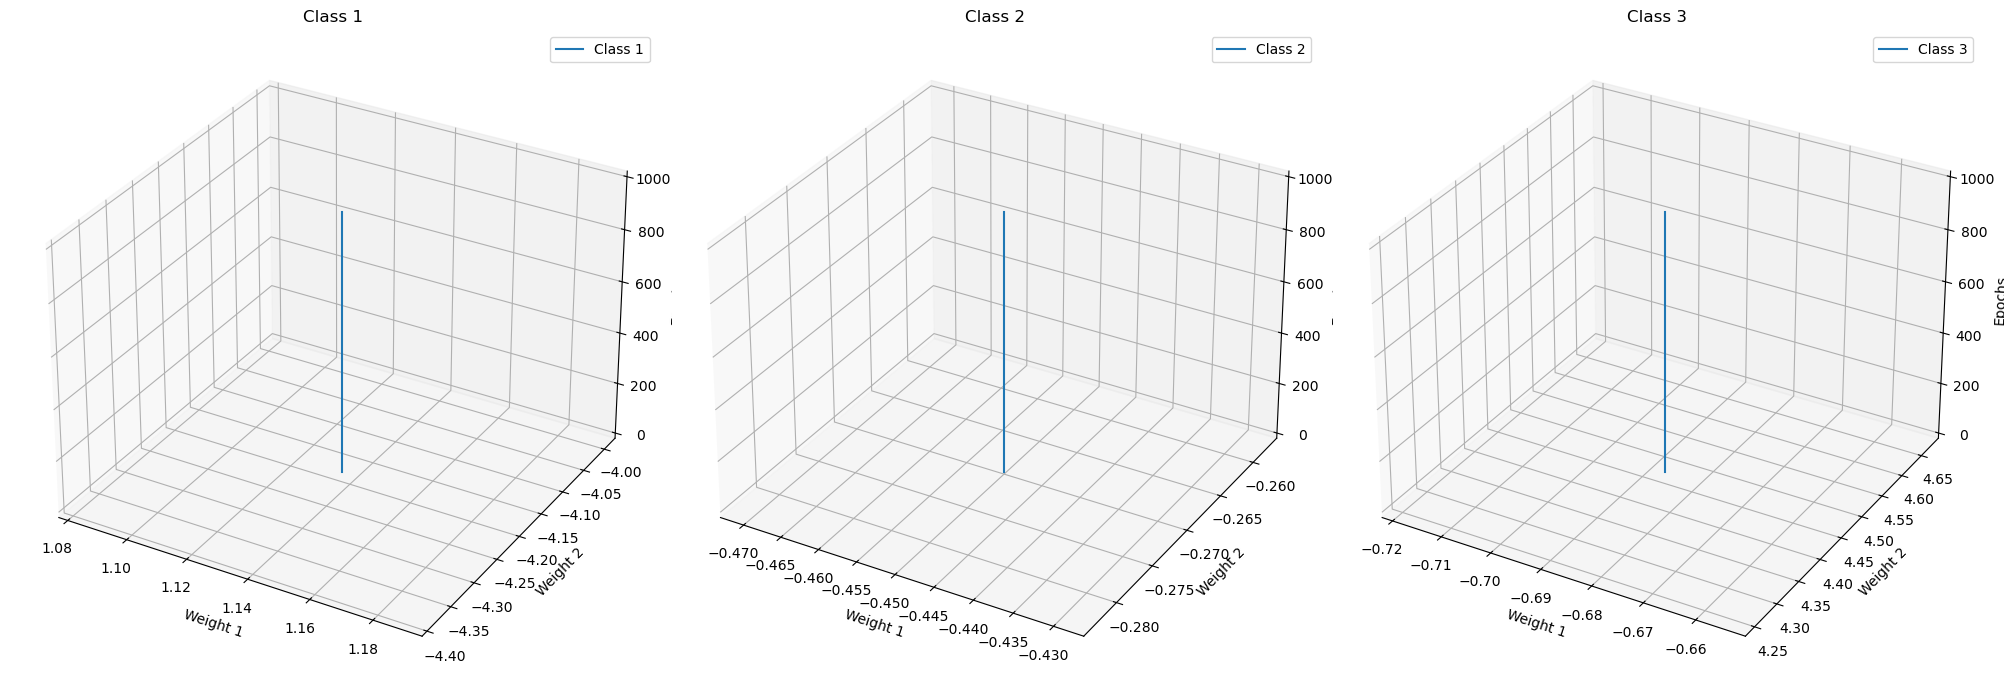

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming Weights_array and Bias_array are already defined
Weights_array = np.array(model.Weights_array)
Bias_array = np.array(model.Bias_array)

# Extracting the weights for each class
class_1_feature_1 = Weights_array[:, 0, 0]
class_1_feature_2 = Weights_array[:, 1, 0]
class_2_feature_1 = Weights_array[:, 0, 1]
class_2_feature_2 = Weights_array[:, 1, 1]
class_3_feature_1 = Weights_array[:, 0, 2]
class_3_feature_2 = Weights_array[:, 1, 2]

epochs = np.arange(Weights_array.shape[0])

# Creating a figure with 3 subplots
fig = plt.figure(figsize=(20, 10))

# Subplot 1 for Class 1
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot(class_1_feature_1, class_1_feature_2, epochs, label='Class 1')
ax1.set_xlim([class_1_feature_1.min() , class_1_feature_1.max() ])
ax1.set_ylim([class_1_feature_2.min() , class_1_feature_2.max() ])
ax1.set_zlim([0, epochs.max()])
ax1.set_xlabel('Weight 1')
ax1.set_ylabel('Weight 2')
ax1.set_zlabel('Epochs')
ax1.set_title('Class 1')
ax1.legend()

# Subplot 2 for Class 2
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot(class_2_feature_1, class_2_feature_2, epochs, label='Class 2')
ax2.set_xlim([class_2_feature_1.min() , class_2_feature_1.max() ])
ax2.set_ylim([class_2_feature_2.min() , class_2_feature_2.max() ])
ax2.set_zlim([0, epochs.max()])
ax2.set_xlabel('Weight 1')
ax2.set_ylabel('Weight 2')
ax2.set_zlabel('Epochs')
ax2.set_title('Class 2')
ax2.legend()

# Subplot 3 for Class 3
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot(class_3_feature_1, class_3_feature_2, epochs, label='Class 3')
ax3.set_xlim([class_3_feature_1.min() , class_3_feature_1.max() ])
ax3.set_ylim([class_3_feature_2.min() , class_3_feature_2.max() ])
ax3.set_zlim([0, epochs.max()])
ax3.set_xlabel('Weight 1')
ax3.set_ylabel('Weight 2')
ax3.set_zlabel('Epochs')
ax3.set_title('Class 3')
ax3.legend()

plt.tight_layout()
plt.show()


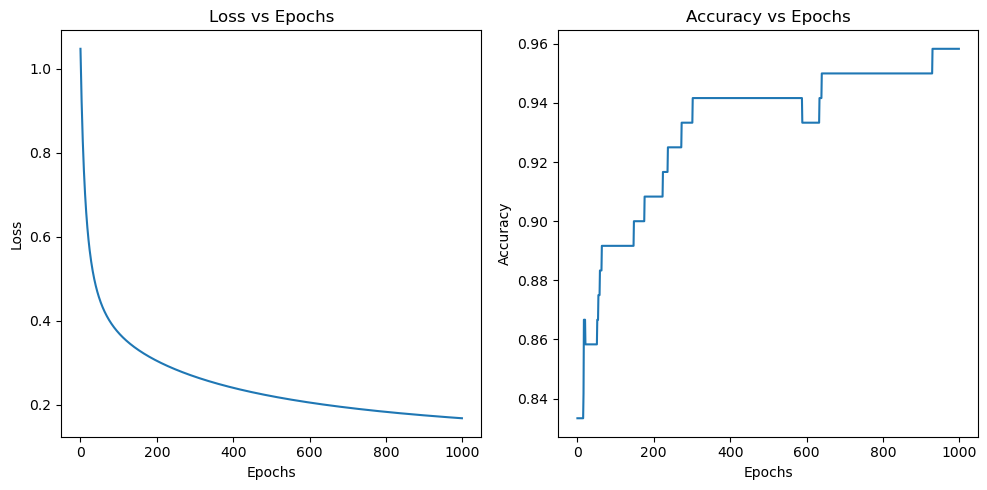

In [41]:
# Making 2 graphs
# 1 for Loss vs Epochs
# 1 for Accuracy vs Epochs

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(np.arange(len(model.loss_array)), model.loss_array)
ax[0].set_title('Loss vs Epochs')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(np.arange(len(model.accuracy_array)), model.accuracy_array)
ax[1].set_title('Accuracy vs Epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
plt.tight_layout()

plt.show()


In [42]:
# training the model using PyTorch on Cifar100 dataset
import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch

RANDOM_SEED = 123
LEARNING_RATE = 0.1
BATCH_SIZE = 8
N_EPOCHS = 1000

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.CIFAR100(root='data',
                                   train=True,
                                   transform=transforms.ToTensor(),
                                   download=True)

test_dataset = datasets.CIFAR100(root='data', 
                                  train=False,
                                  transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break


torch.manual_seed(RANDOM_SEED)
# loading the model on GPU
model = Logistic_torch(X_train, y_train, N_EPOCHS, LEARNING_RATE)
model = model.to(device)
model.train()

model2 = Logistic(X_train.numpy(),y_train.numpy(),N_EPOCHS,LEARNING_RATE)
model2.train_stochastic()


# testing the model
test_acc = model.test_accuracy(X_test, y_test)
print(f'\nTest accuracy: {test_acc:.2f}')

test_acc2 = model2.test_accuracy(X_test.numpy(), y_test.numpy())
print(f'\nTest accuracy: {test_acc2:.2f}')

Files already downloaded and verified
Image batch dimensions: torch.Size([8, 3, 32, 32])
Image label dimensions: torch.Size([8])
Epoch : 1 || Loss => 1.0986 || Accuracy => 0.3417
----------------------
Epoch : 2 || Loss => 1.0553 || Accuracy => 0.8333
----------------------
Epoch : 3 || Loss => 1.0154 || Accuracy => 0.8333
----------------------
Epoch : 4 || Loss => 0.9787 || Accuracy => 0.8333
----------------------
Epoch : 5 || Loss => 0.9450 || Accuracy => 0.8333
----------------------
Epoch : 6 || Loss => 0.9139 || Accuracy => 0.8333
----------------------
Epoch : 7 || Loss => 0.8853 || Accuracy => 0.8333
----------------------
Epoch : 8 || Loss => 0.8589 || Accuracy => 0.8333
----------------------
Epoch : 9 || Loss => 0.8346 || Accuracy => 0.8333
----------------------
Epoch : 10 || Loss => 0.8120 || Accuracy => 0.8333
----------------------
Epoch : 11 || Loss => 0.7912 || Accuracy => 0.8333
----------------------
Epoch : 12 || Loss => 0.7718 || Accuracy => 0.8333
---------------

In [43]:
! pip install torch

In [44]:
! pip install torch torchvision

In [45]:
# ! pip install keras
! pip install tensorflow

In [46]:
import numpy as np
from keras.datasets import mnist

# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255
model = Logistic(train_images,train_labels,1000,0.001)
model.train_stochastic()
print("Test Accuracy: ",model.test_accuracy(test_images,test_labels))

model_batch = Logistic(train_images,train_labels,1000,0.001)
model_batch.train()
print("Test Accuracy: ",model_batch.test_accuracy(test_images,test_labels))

Epoch : 1 || Loss => 0.3827 || Accuracy => 0.8930
----------------------
Epoch : 2 || Loss => 0.3402 || Accuracy => 0.9035
----------------------
Epoch : 3 || Loss => 0.3213 || Accuracy => 0.9095
----------------------
Epoch : 4 || Loss => 0.3099 || Accuracy => 0.9127
----------------------
Epoch : 5 || Loss => 0.3021 || Accuracy => 0.9149
----------------------
Epoch : 6 || Loss => 0.2962 || Accuracy => 0.9163
----------------------
Epoch : 7 || Loss => 0.2917 || Accuracy => 0.9179
----------------------
Epoch : 8 || Loss => 0.2879 || Accuracy => 0.9186
----------------------
Epoch : 9 || Loss => 0.2848 || Accuracy => 0.9197
----------------------
Epoch : 10 || Loss => 0.2821 || Accuracy => 0.9206
----------------------
Epoch : 11 || Loss => 0.2798 || Accuracy => 0.9212
----------------------
Epoch : 12 || Loss => 0.2778 || Accuracy => 0.9218
----------------------
Epoch : 13 || Loss => 0.2759 || Accuracy => 0.9224
----------------------
Epoch : 14 || Loss => 0.2743 || Accuracy => 0.9

KeyboardInterrupt: 

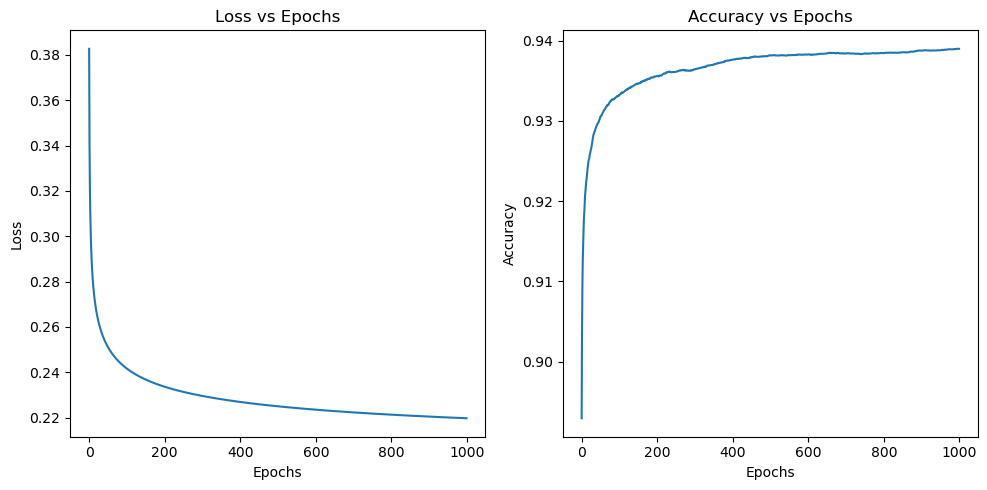

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(np.arange(len(model.loss_array)), model.loss_array)
ax[0].set_title('Loss vs Epochs')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(np.arange(len(model.accuracy_array)), model.accuracy_array)
ax[1].set_title('Accuracy vs Epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
plt.tight_layout()

plt.show()

In [47]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to the range [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

print(f"Training data shape: {x_train.shape}, Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}, Test labels shape: {y_test.shape}")


Training data shape: (50000, 32, 32, 3), Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3), Test labels shape: (10000, 1)


In [ ]:
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

model = Logistic(x_train,y_train,10,0.001)
model.train_stochastic()
print("Test Accuracy: ",model.test_accuracy(x_test,y_test))



Epoch : 1 || Loss => 2.3026 || Accuracy => 1.0000
----------------------
Epoch : 2 || Loss => 2.3026 || Accuracy => 1.0000
----------------------
Epoch : 3 || Loss => 2.3026 || Accuracy => 1.0000
----------------------
Epoch : 4 || Loss => 2.3026 || Accuracy => 1.0000
----------------------
Epoch : 5 || Loss => 2.3026 || Accuracy => 1.0000
----------------------
Epoch : 6 || Loss => 2.3026 || Accuracy => 1.0000
----------------------
Epoch : 7 || Loss => 2.3026 || Accuracy => 1.0000
----------------------
Epoch : 8 || Loss => 2.3026 || Accuracy => 1.0000
----------------------
Epoch : 9 || Loss => 2.3026 || Accuracy => 1.0000
----------------------
Epoch : 10 || Loss => 2.3026 || Accuracy => 1.0000
----------------------
Test Accuracy:  1.0


In [ ]:
print(x_train.shape)
print(y_train.shape)

(50000, 3072)
(50000, 1)


In [48]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# Normalize the images to the range [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

print(f"Training data shape: {x_train.shape}, Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}, Test labels shape: {y_test.shape}")

x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

model_batch = Logistic(x_train,y_train,1000,0.001)
model_batch.train()
print("Test Accuracy: ",model_batch.test_accuracy(x_test,y_test))

model = Logistic(x_train,y_train,1000,0.001)
model.train_stochastic()
print("Test Accuracy: ",model.test_accuracy(x_test,y_test))



Training data shape: (50000, 32, 32, 3), Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3), Test labels shape: (10000, 1)
Epoch : 1 || Loss => 4.6052 || Accuracy => 1.0000
----------------------
Epoch : 2 || Loss => 4.6052 || Accuracy => 0.8357
----------------------
Epoch : 3 || Loss => 4.6052 || Accuracy => 1.0000
----------------------
Epoch : 4 || Loss => 4.6052 || Accuracy => 0.0000
----------------------
Epoch : 5 || Loss => 4.6052 || Accuracy => 1.0000
----------------------
Epoch : 6 || Loss => 4.6054 || Accuracy => 0.0000
----------------------
Epoch : 7 || Loss => 4.5692 || Accuracy => 1.0000
----------------------
Epoch : 8 || Loss => 332.5424 || Accuracy => 0.0000
----------------------
Epoch : 9 || Loss => 4.5643 || Accuracy => 1.0000
----------------------
Epoch : 10 || Loss => 4.5643 || Accuracy => 1.0000
----------------------
Epoch : 11 || Loss => 4.5643 || Accuracy => 1.0000
----------------------
Epoch : 12 || Loss => 4.5643 || Accuracy => 1.0000


KeyboardInterrupt: 